In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00:00:0100:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from sklearn.model_selection import train_test_split

In [5]:
import os
import rasterio
from PIL import Image

image_folder = '/kaggle/input/water-seg-data/data/images'  
label_folder = '/kaggle/input/water-seg-data/data/labels'  

# Lists to store data
X = []
y = []

for filename in os.listdir(image_folder):
    if filename.endswith('.tif'):
        # Get corresponding label filename
        label_filename = filename.replace('.tif', '.png')
        
        # Read TIF file with all bands
        with rasterio.open(os.path.join(image_folder, filename)) as src:
            image = src.read()  # This will read all bands
            # Transpose from (C, H, W) to (H, W, C)
            image = np.transpose(image, (1, 2, 0))
            
        # Read PNG label
        label = np.array(Image.open(os.path.join(label_folder, label_filename)))
        # Convert label to binary
        label = (label > 0).astype(np.float32)
        
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Add channel dimension to labels
y = np.expand_dims(y, axis=-1)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Data shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128, 1)


In [6]:
def normalize_bands(X):
    X_normalized = np.zeros_like(X, dtype=np.float32)
    for i in range(X.shape[-1]):  # For each band
        band = X[..., i]
        mean = np.mean(band)
        std = np.std(band)
        X_normalized[..., i] = (band - mean) / (std + 1e-8)
    return X_normalized

X_normalized = normalize_bands(X)

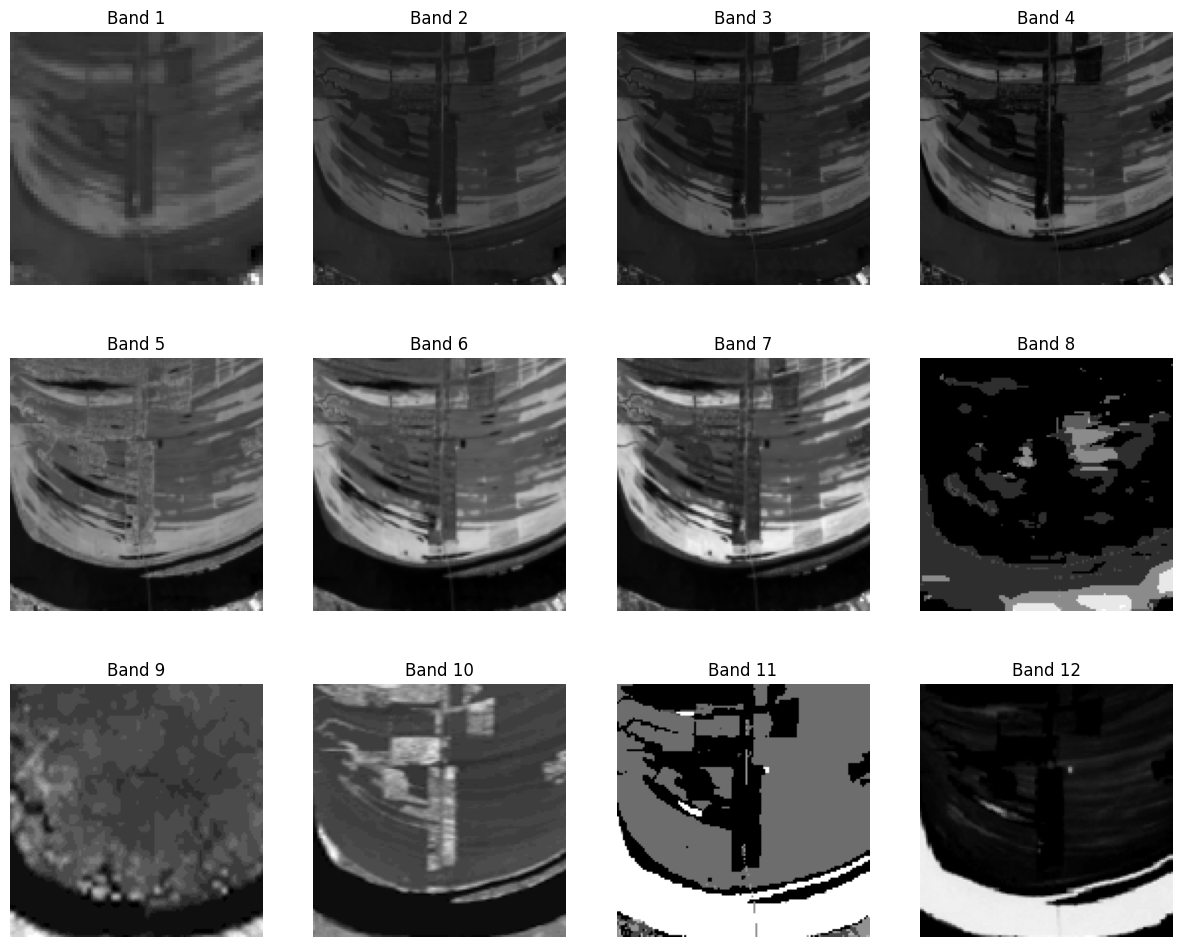

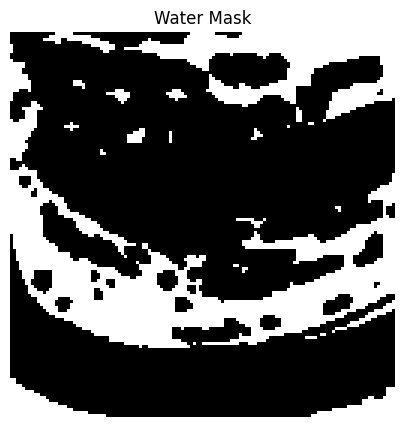

In [7]:
def plot_sample(X_sample, y_sample, sample_idx):
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(12):
        axes[i].imshow(X_sample[sample_idx, :, :, i], cmap='gray')
        axes[i].set_title(f'Band {i+1}')
        axes[i].axis('off')
    
    plt.figure(figsize=(5, 5))
    plt.imshow(y_sample[sample_idx, :, :, 0], cmap='binary')
    plt.title('Water Mask')
    plt.axis('off')
    plt.show()

# Visualize first sample
plot_sample(X_normalized, y, 0)

In [9]:
# Split into train, validation, and test sets (70%, 15%, 15%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (214, 128, 128, 12)
Validation set shape: (46, 128, 128, 12)
Test set shape: (46, 128, 128, 12)


# DeepLabV3+
# note: i implemented A ResNet like architecture. 

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def ASPP(inputs):
    shape = inputs.shape

    # Global average pooling branch
    y_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    y_pool = tf.keras.layers.Reshape((1, 1, shape[-1]))(y_pool)
    y_pool = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(y_pool)
    y_pool = tf.keras.layers.BatchNormalization()(y_pool)
    y_pool = tf.keras.layers.Activation('relu')(y_pool)
    y_pool = tf.keras.layers.UpSampling2D(size=(shape[1], shape[2]), interpolation='bilinear')(y_pool)

    # 1x1 convolution branch
    y_1 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(inputs)
    y_1 = tf.keras.layers.BatchNormalization()(y_1)
    y_1 = tf.keras.layers.Activation('relu')(y_1)

    # 3x3 convolution with rate 6 branch
    y_6 = tf.keras.layers.Conv2D(256, 3, padding='same', dilation_rate=6, use_bias=False)(inputs)
    y_6 = tf.keras.layers.BatchNormalization()(y_6)
    y_6 = tf.keras.layers.Activation('relu')(y_6)

    # 3x3 convolution with rate 12 branch
    y_12 = tf.keras.layers.Conv2D(256, 3, padding='same', dilation_rate=12, use_bias=False)(inputs)
    y_12 = tf.keras.layers.BatchNormalization()(y_12)
    y_12 = tf.keras.layers.Activation('relu')(y_12)

    # 3x3 convolution with rate 18 branch
    y_18 = tf.keras.layers.Conv2D(256, 3, padding='same', dilation_rate=18, use_bias=False)(inputs)
    y_18 = tf.keras.layers.BatchNormalization()(y_18)
    y_18 = tf.keras.layers.Activation('relu')(y_18)

    # Concatenate all branches
    y = tf.keras.layers.Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    # Final 1x1 convolution
    y = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    return y

def DeepLabV3Plus(input_shape=(128, 128, 12), num_classes=1):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial convolution block to handle 12 channels
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)  # 64x64
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Store the low-level features before pooling
    low_level_features = x  # 64x64
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)  # 32x32
    
    # blocks simmilar to Resnet 
    # Block 1
    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)  # 16x16
    
    # Block 2
    x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)  # 8x8
    
    # ASPP
    x = ASPP(x)  # 8x8
    
    # Process low-level features
    low_level_features = tf.keras.layers.Conv2D(48, 1, padding='same', use_bias=False)(low_level_features)
    low_level_features = tf.keras.layers.BatchNormalization()(low_level_features)
    low_level_features = tf.keras.layers.Activation('relu')(low_level_features)
    
    # Upsample ASPP features
    x = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(x)  # 64x64
    
    # Concatenate with low-level features
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    
    # Final convolutions
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    
    # Upsample to original size
    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # 128x128
    
    # Final 1x1 convolution
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create model
model = DeepLabV3Plus(input_shape=(128, 128, 12))

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         37,696 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 128)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 128)    │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 16, 16, 256)    │          1,024 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 16, 16, 256)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ activation_6[0][0]     │
├──────────────────────

 Total params: 4,676,353 (17.84 MB)

 Trainable params: 4,671,521 (17.82 MB)

 Non-trainable params: 4,832 (18.88 KB)

In [16]:

callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

In [17]:
# Train model
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8210 - io_u: 0.0000e+00 - loss: 0.4099 - val_accuracy: 0.7302 - val_io_u: 0.0000e+00 - val_loss: 0.5491 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8780 - io_u: 0.0000e+00 - loss: 0.3083 - val_accuracy: 0.8452 - val_io_u: 0.0000e+00 - val_loss: 0.3404 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8828 - io_u: 0.0000e+00 - loss: 0.2816 - val_accuracy: 0.7841 - val_io_u: 0.0000e+00 - val_loss: 0.3887 - learning_rate: 1.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8891 - io_u: 0.0000e+00 - loss: 0.2521 - val_accuracy: 0.8924 - val_io_u: 0.0000e+00 - val_loss: 0.2996 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9007 - io_u: 0.0000e+00 - loss: 0.2437 - val_accuracy: 0.9002 - val_io_u: 0.0000e+00 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 6/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


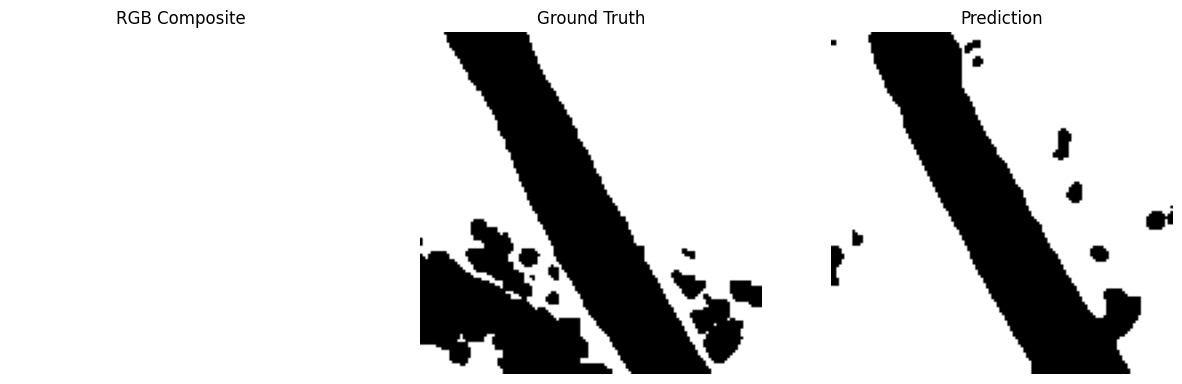

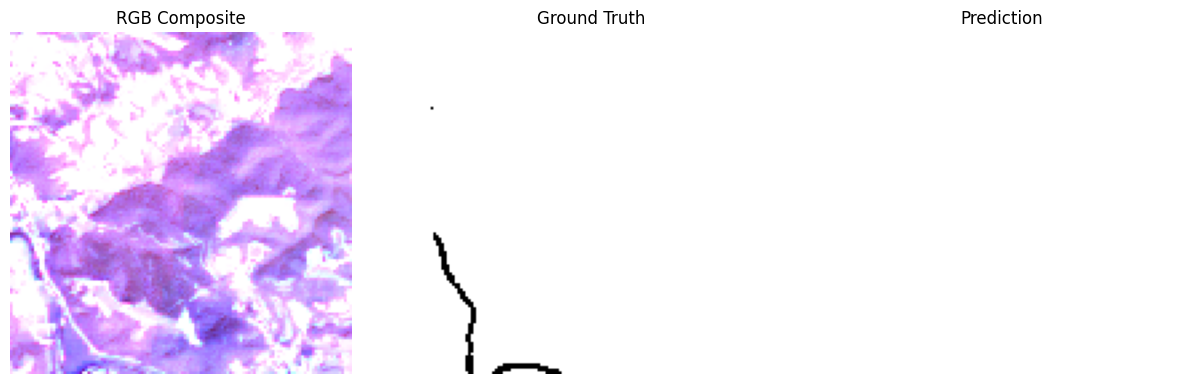

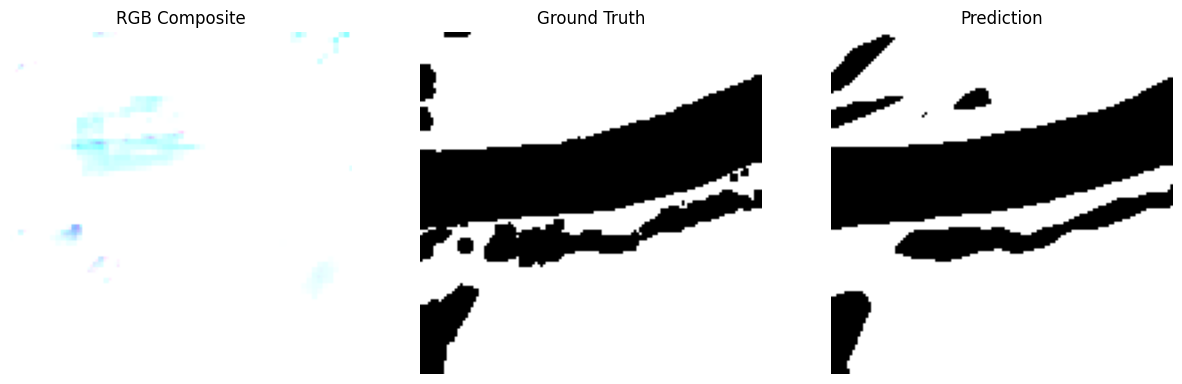

In [31]:
def visualize_predictions(X_test, y_test, model, num_samples=3):
    predictions = model.predict(X_test[:num_samples])
    
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i, :, :, :3])
        plt.title('RGB Composite')
        plt.axis('off')
        
        # Display ground truth
        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i, :, :, 0], cmap='binary')
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Display prediction
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i, :, :, 0] > 0.5, cmap='binary')
        plt.title('Prediction')
        plt.axis('off')
        
        plt.show()

visualize_predictions(X_test, y_test, model)

In [19]:
#Calculate metrics
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(np.float32)
    
    # Calculate IoU
    intersection = np.sum(y_true * y_pred_binary)
    union = np.sum(y_true) + np.sum(y_pred_binary) - intersection
    iou = intersection / (union + 1e-8)
    
    # Calculate Precision
    precision = intersection / (np.sum(y_pred_binary) + 1e-8)
    
    # Calculate Recall
    recall = intersection / (np.sum(y_true) + 1e-8)
    
    # Calculate F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return {
        'IoU': iou,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

# Get predictions on test set
test_predictions = model.predict(X_test)
metrics = calculate_metrics(y_test, test_predictions)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 821ms/step
IoU: 0.7840
Precision: 0.9257
Recall: 0.8367
F1: 0.8789
